# **Main notebook**

# Pytorch model


In [1]:
# Prep Error Suppressing >>>
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Base and torch >>>
import gc
import os
import glob
import time
import torch
import pickle
import shutil
import datetime
import contextlib
import torchvision
import numpy as np
import multiprocessing
from tqdm import tqdm
import seaborn as sns
from numba import cuda
from zipfile import ZipFile
from torch import nn, optim
import matplotlib.pyplot as plt
from typing import Literal
from torchsummary import summary
from numba.cuda.cudadrv import enums
from torch.nn.functional import one_hot
from efficientnet_pytorch import EfficientNet
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter  # type: ignore
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Utils
from Utils.print_color_V2_NEW import print_Color_V2  # noqa: F401
from Utils.print_color_V1_OLD import print_Color
from Utils.adabound import AdaBound  # noqa: F401

c:\Users\aydin\Desktop\PyTorch Project Template\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prep

In [2]:
# Conf >>>
CPU_only = False
torch.set_num_threads(multiprocessing.cpu_count())

# Get the current device info >>>
device_C = cuda.get_current_device()
attribs = [
    name.replace("CU_DEVICE_ATTRIBUTE_", "")
    for name in dir(enums)
    if name.startswith("CU_DEVICE_ATTRIBUTE_")
]

with open("GPU_Info.txt", "w") as f:
    for attr in attribs:
        f.write(f"{attr} = {getattr(device_C, attr)}\n")
# Get the current device for torch >>>
device = torch.device("cuda" if torch.cuda.is_available() and not CPU_only else "cpu")
print(f"Chosen device: {device}")
if device.type == "cuda":
    device_name = torch.cuda.get_device_name(device)
    device_capability = torch.cuda.get_device_capability(device)
    print(f"CUDA │ Device Name: {device_name}")
    print(f"CUDA │ Device Capability: {device_capability}")


# Get the current device for model >>>
def get_device(model):
    """
    Returns the device type (either "cpu" or "cuda") for the given PyTorch model.

    Args:
        model (torch.nn.Module): The PyTorch model to get the device for.

    Returns:
        str: The device type as a string, either "cpu" or "cuda".
    """
    return str(next(model.parameters()).device).split(":")[0]

Chosen device: cuda
CUDA │ Device Name: NVIDIA GeForce RTX 3090
CUDA │ Device Capability: (8, 6)


## Conf


### Data processing conf

In [3]:
# Directory paths for training, test and validation image data >>>
# base │
base_dir = "Database\\Data"
# cache |
cache_dir = "Database\\cache"
# Image resolution
img_res = [224, 224, 3]
# Data type
dtype = torch.float32  # Do not chnage it (Not recommended)
# Augmentation
Augmentation = (
    False  # I had better results with augmentation off and with the orginal data
)
# capitalize_label
capitalize_label = True
# Split
TT_split = 0.75
# Always Create dataset from base
dc_mode = (
    1  # Dataset - Creation . Mode | 0 = Do not always | 1 = Always create from base
)
# class weight algorithm
class_weight_algorithm = "linear"

## data processing 


In [4]:
# Define the data labels
labels = (
    [label.capitalize() for label in os.listdir(base_dir)]
    if capitalize_label
    else os.listdir(base_dir)
)
# Define a data transformer >>>
transform_load = transforms.Compose(
    [
        transforms.Resize(img_res[:-1]),  # Resize images to img_res
        transforms.ToTensor(),  # Convert image to PyTorch Tensor data type
        transforms.ConvertImageDtype(dtype),  # ConvertImageDtype
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Lambda(
            lambda x: (x - x.min()) / (x.max() - x.min())
        ),  # Normalize the normalized data to range 0 to 1
    ]
)
transform_augmentation = transforms.Compose(
    [
        transforms.RandomAutocontrast(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.ElasticTransform(),
        transforms.ColorJitter(brightness=0.4, contrast=0.38, saturation=0.3, hue=0.2),
        transforms.RandomCrop(224, padding=32),
        transforms.RandomPerspective(distortion_scale=0.5),
        transforms.RandomAffine(45),
    ]
)


# Auxiliary funcs
def augment_images(images, labels, passes, transform_augmentation):
    """
    Augments the given images and labels by applying random transformations.

    This function takes a batch of images and labels, and augments them by
    applying the given transform_augmentation randomly. It performs this
    augmentation for the specified number of passes.

    For each pass, it iterates through the images and labels, applies the
    transform_augmentation, and replaces the original images and labels with
    the augmented ones.

    Args:
        images: The batch of original images.
        labels: The labels corresponding to the images.
        passes: The number of augmentation passes to perform.
        transform_augmentation: The transformation to apply.

    Returns:
        augmented_images: The augmented images.
        augmented_labels: The augmented labels.
    """

    # Augmentation passes
    for Pass in range(passes):
        print_Color(
            f" │ ~*Augmentation pass: ~*[{Pass+1}/{passes}]",
            ["cyan", "green"],
            advanced_mode=True,
        )
        # Initialize the augmented images and labels lists
        augmented_images_temp = images.clone()
        augmented_labels_temp = labels.clone()
        for i in tqdm(
            range(len(augmented_images_temp)),
            desc=" │ │ \x1b[0;36mAugmenting data\x1b[0m",
        ):
            image = augmented_images_temp[i]
            label = augmented_labels_temp[i]
            # Apply the transformations
            augmented_image = transform_augmentation(image)
            # Replace the original image and label with the augmented ones
            augmented_images_temp[i] = augmented_image
            augmented_labels_temp[i] = label
        # Add the images and labels
        if Pass != 0:
            augmented_images = torch.cat([augmented_images, augmented_images_temp])  # type: ignore # noqa: F821
            augmented_labels = torch.cat([augmented_labels, augmented_labels_temp])  # type: ignore # noqa: F821
        else:
            augmented_images = augmented_images_temp
            augmented_labels = augmented_labels_temp
    print_Color(" │ ~*Shuffling all batches...", ["cyan"], advanced_mode=True)
    indices = torch.randperm(len(augmented_labels)).tolist()
    augmented_images = torch.stack([augmented_images[i] for i in indices])
    augmented_labels = [augmented_labels[i] for i in indices]

    # End
    return augmented_images, torch.tensor(augmented_labels)


def compute_class_weights_one_hot(
    y: torch.Tensor,
    weighting: Literal[
        "square", "sqrt", "1p5_Power", "cube", "harmonic", "log", "linear"
    ] = "linear",
):
    """Computes normalized class weights for one-hot encoded labels.

    This computes the inverse frequency of each class in the provided
    one-hot encoded labels, and then
    applies the specified weighting scheme, and returns the normalized class weights.

    Parameters:
    y (Tensor): One-hot encoded labels.
    weighting (str): The weighting scheme to apply. Options are 'square', 'sqrt', '1p5_Power', 'cube', 'harmonic', 'log', and 'linear'.

    Returns:
    Tensor: The normalized class weights.

    Intended for computing loss weighting to handle class imbalance.
    """
    # Convert one-hot encoded labels to class labels
    class_labels = torch.argmax(y, dim=1)

    # Count the number of samples in each class
    class_sample_counts = torch.bincount(class_labels)

    # Compute the inverse of each class count
    class_weights = 1.0 / class_sample_counts.float()

    # Apply the specified weighting scheme
    if weighting == "square":
        class_weights = class_weights**2
    elif weighting == "sqrt":
        class_weights = class_weights.sqrt()
    elif weighting == "cube":
        class_weights = class_weights**3
    elif weighting == "1p5_Power":
        class_weights = class_weights**1.5
    elif weighting == "log":
        class_weights = torch.log(class_weights)
    elif weighting != "linear":
        raise ValueError(f"Unknown weighting scheme '{weighting}'")

    # Normalize the class weights so that they sum to 1
    class_weights_normalized = class_weights / class_weights.sum()

    # Return the normalized class weights
    return class_weights_normalized


def save_samples(images, labels, num_samples, data_type):
    """Saves sample images along with their labels.

    This function takes in a batch of images and labels, selects num_samples of them,
    converts the images to the specified data type, saves them in a dated folder,
    zips the folder, deletes the unzipped folder, and returns nothing.

    The labels are converted from one-hot encoding to integers if needed.
    A progress bar is displayed while saving the images.
    """
    # Convert the data to the desired type
    images = images.type(data_type)

    # Save num_samples sample images
    samples_dir = "samples"
    os.makedirs(samples_dir, exist_ok=True)

    # If labels are one-hot encoded, convert them to numerical labels
    if len(labels.shape) > 1 and labels.shape[1] > 1:
        labels = torch.argmax(labels, dim=1)

    # Create a folder with the current date and time
    date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(f"{samples_dir}/{date_time}", exist_ok=True)

    # Use tqdm for the progress bar
    for i, (image, label) in enumerate(
        tqdm(
            zip(images, labels),
            total=num_samples,
            desc=" │ \x1b[0;36mSaving imgs\x1b[0m",
        )
    ):
        if i >= num_samples:
            break
        torchvision.utils.save_image(
            image, f"{samples_dir}/{date_time}/sample_{i}_label_{label.item()}.png"
        )

    # Compress the new folder
    with ZipFile(f'{f"{samples_dir}/{date_time}"}.zip', "w") as zipf:
        for foldername, subfolders, filenames in os.walk(f"{samples_dir}/{date_time}"):
            for filename in filenames:
                zipf.write(os.path.join(foldername, filename))

    # Delete the original folder
    time.sleep(0.2)
    shutil.rmtree(f"{samples_dir}/{date_time}")


def split_data(x_base, y_base, train_ratio=0.8):
    """Splits the input data into train and test sets.

    Args:
    x_base: Tensor containing the input data
    y_base: Tensor containing the labels
    train_ratio: Ratio of data to use for training set

    Returns:
    x_train: Input data for the training set
    y_train: Labels for the training set
    x_test: Input data for the test set
    y_test: Labels for the test set

    Splits the input data into train and test sets based on the
    provided train_ratio. Returns DataLoader objects for the
    train and test sets.
    """
    # Create a dataset from the tensors
    dataset = TensorDataset(x_base, y_base)

    # Determine the lengths of the splits
    train_len = int(train_ratio * len(dataset))
    test_len = len(dataset) - train_len

    # Create the random splits
    train_data, test_data = random_split(dataset, [train_len, test_len])

    # Create data loaders for the training and test sets
    train_loader = DataLoader(train_data, batch_size=len(train_data))
    test_loader = DataLoader(test_data, batch_size=len(test_data))

    # Extract the data and labels for the training set
    x_train, y_train = next(iter(train_loader))

    # Extract the data and labels for the test set
    x_test, y_test = next(iter(test_loader))

    return x_train, y_train, x_test, y_test


# Load the data to memory >>>
# Define a function to load the dataset
def load_dataset(directory, cache_dir, transform, dc_mode):
    """Loads image data and labels from a directory.

    Caches the loaded data to speed up future loads. Checks for a cached version first before loading from scratch.

    Args:
    directory: Path to data directory.
    cache_dir: Path to cache directory.
    transform: Transform to apply to each image.
    dc_mode: If 1, special case to not use cache.

    Returns:
    data: Tensor of loaded image data.
    labels: Tensor of labels for each image.

    """
    cache_file = os.path.join(cache_dir, os.path.basename(directory) + ".pkl")
    os.makedirs(cache_dir, exist_ok=True)
    # Check if cache exists
    if os.path.exists(cache_file) and dc_mode != 1:
        print_Color(
            f" │ │ ~*Loading cached data from: ~*{cache_file}",
            ["cyan", "green"],
            advanced_mode=True,
        )
        with open(cache_file, "rb") as f:
            data, labels = pickle.load(f)
    else:
        print_Color(
            f" │ │ ~*Loading data from directory: ~*{directory}",
            ["cyan", "green"],
            advanced_mode=True,
        )
        dataset = datasets.ImageFolder(root=directory, transform=transform)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)  # type: ignore

        data, labels = [], []
        for image, label in tqdm(
            data_loader, desc=" │ │ │ \x1b[0;36mLoading data\x1b[0m", unit="img"
        ):
            data.append(image)
            labels.append(label)

        # Shuffle the data and labels
        print_Color(" │ │ │ ~*Shuffling all batches...", ["cyan"], advanced_mode=True)
        indices = torch.randperm(len(data))
        data = [data[i] for i in indices]
        labels = [labels[i] for i in indices]

        print_Color(" │ │ │ ~*Concatenate all batches...", ["cyan"], advanced_mode=True)
        data = torch.cat(data, 0)
        labels = torch.cat(labels, 0)

        # Cache the data and labels
        print_Color(
            f" │ │ ~*Caching data to: ~*{cache_file}",
            ["cyan", "green"],
            advanced_mode=True,
        )
        with open(cache_file, "wb") as f:
            pickle.dump((data, labels), f)

    return data, labels


# Load the datasets
print_Color("Loading dataset...", ["yellow"])
print_Color(" │ ~*Loading base data...", ["cyan"], advanced_mode=True)
x_base, y_base = load_dataset(base_dir, cache_dir, transform_load, dc_mode)
# Split the data
print_Color(
    f"~*Spliting dataset... ~*[Split: {TT_split}]",
    ["yellow", "green"],
    advanced_mode=True,
)
x_train, y_train, x_test, y_test = split_data(x_base, y_base, train_ratio=TT_split)
del x_base, y_base
# Augment the dataset
if Augmentation:
    print_Color("Augment the dataset...", ["yellow"])
    x_train, y_train = augment_images(x_train, y_train, 2, transform_augmentation)

# Convert labels to one-hot encoding
num_classes = torch.unique(y_train).size(0)
print_Color(
    f"~*One-hot encoding dataset... ~*[num_classes: {num_classes}]",
    ["yellow", "cyan"],
    advanced_mode=True,
)
y_train = one_hot(y_train, num_classes=num_classes).float()
y_test = one_hot(y_test, num_classes=num_classes).float()
# compute_class_weights_one_hot
print_Color(
    "Computing class weights...",
    ["yellow"],
    advanced_mode=False,
)
class_weights = compute_class_weights_one_hot(
    y_train,
    weighting=class_weight_algorithm,  # type: ignore
).to(device)
# Save samples
print_Color("Saving img samples...", ["yellow"])
save_samples(x_train, y_train, 320, dtype)
# End
print_Color("Done.", ["green"])

Loading dataset...
 │ Loading base data...
 │ │ Loading data from directory: Database\Data


 │ │ │ Loading data: 100%|██████████| 15515/15515 [00:36<00:00, 419.62img/s]


 │ │ │ Shuffling all batches...
 │ │ │ Concatenate all batches...
 │ │ Caching data to: Database\cache\Data.pkl
Spliting dataset... [Split: 0.75]
One-hot encoding dataset... [num_classes: 12]
Computing class weights...
Saving img samples...


 │ Saving imgs: 100%|██████████| 320/320 [00:03<00:00, 96.38it/s] 


Done.


## Data Analyzation

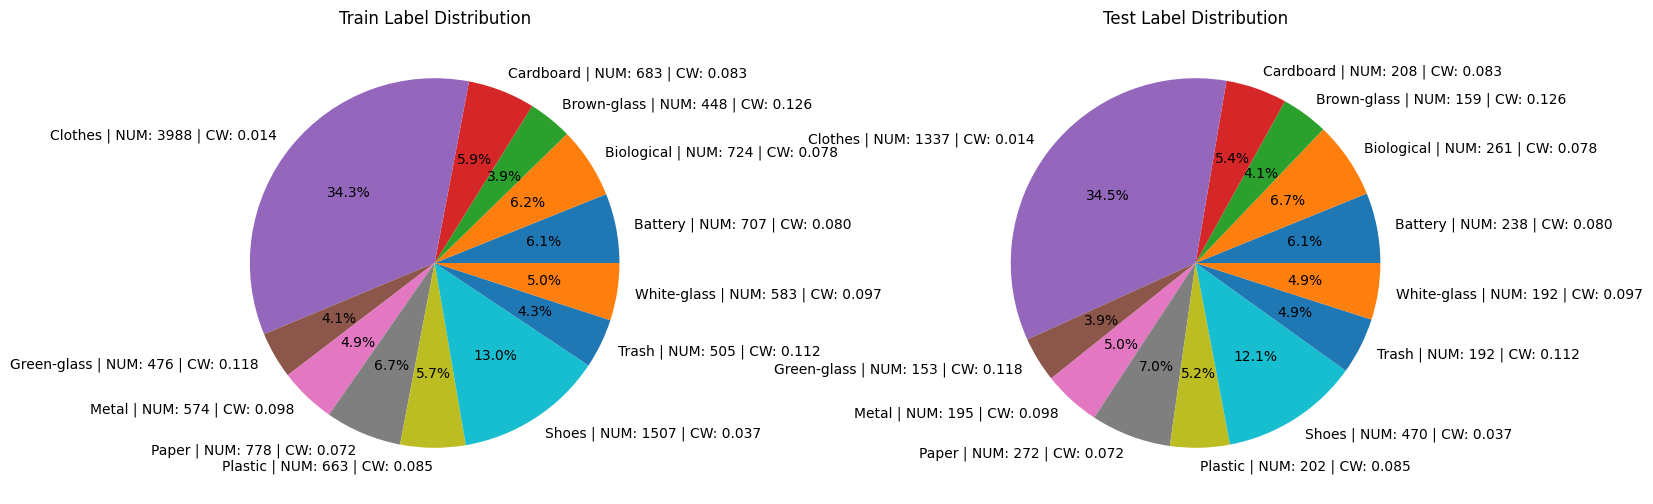

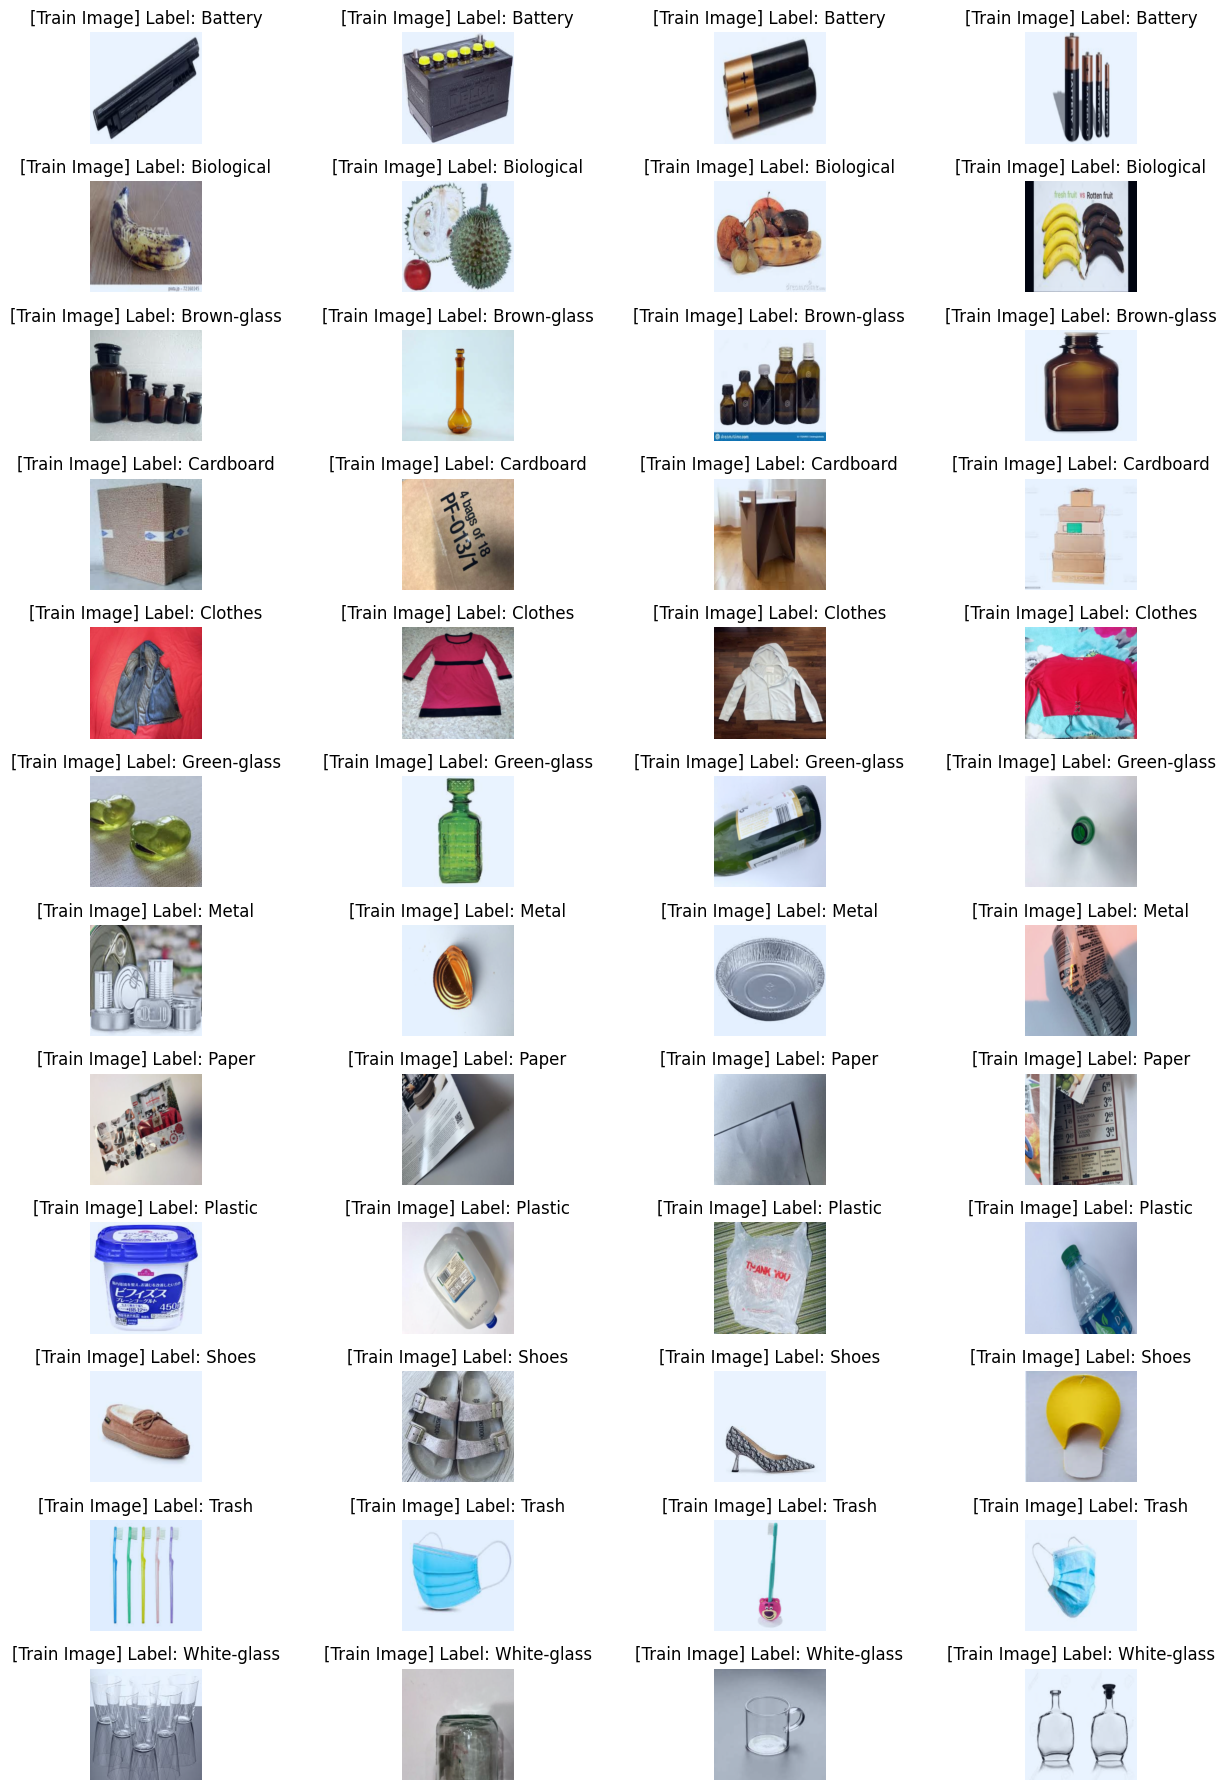

In [23]:
def plot_label_distribution(labels_names, labels, title, subplot):
    _, counts = torch.unique(labels, return_counts=True)
    # Convert counts to string and add to labels for pie chart
    labels_with_counts = [
        f"{label} | NUM: {count} | CW: {class_weight:.3f}"
        for label, count, class_weight in zip(
            labels_names, counts.tolist(), class_weights.tolist()
        )
    ]
    subplot.pie(counts, labels=labels_with_counts, autopct="%1.1f%%")
    subplot.set_title(title)


def plot_example_images(images, labels_names, labels, title, subplot):
    unique_labels = torch.unique(labels)
    for i, label in enumerate(unique_labels):
        # Get the indices of the images that have the current label
        indices = (labels == label).nonzero(as_tuple=True)[0]
        # Select four images from the current label
        selected_images = images[indices[:4]].to(torch.float32)
        for j, image in enumerate(selected_images):
            # Plot the image
            subplot[i, j].imshow(np.transpose(image.numpy(), (1, 2, 0)))
            subplot[i, j].set_title(f"[{title}] Label: {labels_names[i]}")
            subplot[i, j].axis("off")


# Assuming that x_train, y_train, x_test, and y_test are defined
# Create subplots for label distributions
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
plot_label_distribution(
    labels, y_train.argmax(dim=1), "Train Label Distribution", axs[0]
)
plot_label_distribution(labels, y_test.argmax(dim=1), "Test Label Distribution", axs[1])
plt.show()

# Create subplots for example images
# Increase the figure size to make the images bigger
fig, axs = plt.subplots(len(torch.unique(y_train.argmax(dim=1))), 4, figsize=(14, 18))
plot_example_images(x_train, labels, y_train.argmax(dim=1), "Train Image", axs)
plt.tight_layout()
plt.show()

## Creating the model

### EfficientNet-b4

In [5]:
# Load pre-trained EfficientNet-B4
model = EfficientNet.from_pretrained(
    "efficientnet-b4",
    include_top=True,
    num_classes=num_classes,
    dropout_rate=0.11,
)

# Prep
model = model.to(device)

# Summary
summary(model, input_size=(3, 224, 224), device=get_device(model))

Loaded pretrained weights for efficientnet-b4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13        

## Training

In [6]:
# Conf >>>>>>>>>>>>>>>>>>>>>[
Max_epoch = 256
Batch_size = 16
mixed_precision = False  # Use with cuda (GPU)
mixed_precision_type = torch.bfloat16  # Use with cuda (GPU) (can be slower)
EarlyStopping_patience = 12  # Early stopping patience
Training_augmentation = (
    False  # Makes the training slower ⚠️ | but it can improve the results
)
Use_profiler = False  # makes it slow | Debug only
# Conf <<<<<<<<<<<<<<<<<<<<<]
# Opimaization and ... |fn|
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# optimizer = AdaBound(model.parameters(), lr=0.0008, final_lr=0.01, amsbound=False, weight_decay=1e-5) # type: ignore FNT

loss_fn = nn.BCEWithLogitsLoss(weight=class_weights)

TB_log_dir = (
    f"logs\\tensorboard\\{datetime.datetime.now().strftime("y%Y_m%m_d%d-h%H_m%M_s%S")}"
)
tensorboard_writer = SummaryWriter(log_dir=TB_log_dir)
print(f"Tensorboard log dir: {TB_log_dir}")


# Prep
profiler_context_manager = (
    torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=4, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(
            TB_log_dir
        ),  # specify your directory here
        record_shapes=True,
        with_flops=True,
        with_modules=True,
        profile_memory=True,
        with_stack=True,
        activities=[
            torch.profiler.ProfilerActivity.CUDA,
        ],
    )
    if Use_profiler
    else contextlib.nullcontext()
)


# visualize_model_parameters
def visualize_model_parameters(model, epoch):
    """
    Visualize all parameters and tensor attributes of a PyTorch model using TensorBoard.

    This function loops over all the layers in the given model, and for each layer that has parameters or tensor attributes, it adds a histogram of the values to the TensorBoard log.

    Args:
        model (nn.Module): The PyTorch model to visualize.
        epoch (int): The current training epoch, used to organize the TensorBoard logs.
    """
    # Loop over all named parameters in the model
    for name, param in model.named_parameters():
        # Create a unique name for the parameter
        unique_name = f"model/{name.replace('.', '/')}"

        # Add a histogram of the parameter values
        tensorboard_writer.add_histogram(unique_name, param, epoch)

    # Loop over all modules in the model
    for name, module in model.named_modules():
        # Loop over all attributes in the module
        for attr_name, attr_value in module.__dict__.items():
            # Check if the attribute is a tensor and can be logged
            if torch.is_tensor(attr_value):
                # Create a unique name for the attribute
                unique_name = f"{name.replace('.', '/')}/{attr_name}"

                # Add a histogram of the attribute values
                tensorboard_writer.add_histogram(unique_name, attr_value, epoch)


# Earlystoping
def EarlyStopping(
    model,
    Train_state,
    monitor=["loss", "min"],
    min_delta=0,
    patience=24,
    cache_dir="cache\\weights",
    load_best_weights=True,
    verbose=True,
):
    """
    Early stopping utility.

    This function will stop the training process if the monitored metric does not improve for a specified number of epochs (patience).

    Parameters:
    - model (torch.nn.Module): The PyTorch model that is being trained.
    - Train_state (dict): A dictionary that contains the state of the training process. It should include the history of the training and validation metrics.
    - monitor (list): A list of two elements. The first element is the metric to be monitored for the early stopping. The second element is a string indicating whether a higher or lower value of the metric is better. Default is ["loss", "min"].
    - min_delta (float): Minimum change in the monitored quantity to qualify as an improvement. Default is 0.
    - patience (int): Number of epochs with no improvement after which training will be stopped. Default is 24.
    - cache_dir (str): Directory where the model weights will be saved. Default is "cache\\weights".
    - load_best_weights (bool): Whether to load the best weights when the training process is stopped. Default is True.
    - verbose (bool): Whether to print messages about the loading process and the epoch number. Default is True.

    Returns:
    - bool: True if the training process should be stopped, False otherwise.
    """
    # Initialize EarlyStopping data
    if "EarlyStopping_data" not in Train_state:
        Train_state["EarlyStopping_data"] = {
            "best_val_metric": float("inf") if monitor[1] == "min" else float("-inf"),
            "patience": patience,
        }

    es_data = Train_state["EarlyStopping_data"]
    Val_hist = Train_state["Val"]
    current_epoch = len(Val_hist)

    # Get the current metric
    current_val_metric = Val_hist[-1][monitor[0]]

    # Check if the validation loss has improved
    if monitor[1] == "min":
        improved = (es_data["best_val_metric"] - current_val_metric) > min_delta
    else:
        improved = (current_val_metric - es_data["best_val_metric"]) > min_delta

    if improved:
        print_Color(
            f"Model val {monitor} improved from {es_data["best_val_metric"]:.5f} to {current_val_metric:.5f}.",
            ["green"],
        )
        # Save the model weights
        torch.save(
            model.state_dict(),
            os.path.join(cache_dir, f"weights_{current_epoch}.pt"),
        )

        # Update the best_val_metric and reset the patience counter
        es_data["best_val_metric"] = current_val_metric
        es_data["patience"] = patience
    else:
        # Reduce the patience
        es_data["patience"] -= 1

        # Check for early stopping
        if es_data["patience"] == 0:
            if load_best_weights:
                # Load the best weights >>>
                try:
                    # Get the newest file in cache_dir
                    newest_file = max(
                        glob.glob(os.path.join(cache_dir, "*.pt")),
                        key=os.path.getctime,
                    )
                    if verbose:
                        print(
                            f"Loading best weights from epoch {newest_file.split("_")[-1].split(".pt")[0]} with {monitor[0]} {Val_hist[int(newest_file.split("_")[-1].split(".pt")[0]) - 1][monitor[0]]}"
                        )
                    if verbose:
                        print(f"Loading weights from {newest_file}")
                    # Load the weights from the newest file
                    model.load_state_dict(torch.load(newest_file))
                except Exception as Err:
                    print(f"Failed to load weights Err: {Err}")

            return True

    # Delete old weights every 5 epochs but keep the two newest weight
    if current_epoch % 5 == 0:
        files = glob.glob(os.path.join(cache_dir, "*.pt"))
        files.sort(key=os.path.getmtime)
        for file in files[:-2]:  # keep the two newest weight
            os.remove(file)

    return False


# ProgressBar
class ProgressBar(tqdm):
    def __init__(self, *args, **kwargs):
        kwargs["ncols"] = 85
        kwargs["bar_format"] = (
            "(\033[91mTraining\033[00m) {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [Eta: {elapsed}<{remaining}, {rate_fmt}]"
        )
        kwargs["miniters"] = 1
        kwargs["smoothing"] = 0.8
        kwargs["unit"] = ""
        super().__init__(*args, **kwargs)

    def update(self, n=1):
        if self.n + n >= (self.total - 3):  # (self.total - 3) to fix tqdm update issue
            self.bar_format = "(\033[92mComplete\033[00m) {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [Time: {elapsed}, {rate_fmt}]"
        super().update(n)


# fit_step
with profiler_context_manager as profiler:

    def fit_step(x, y, model, optimizer, loss_fn, Use_profiler):
        """Fits a single batch through the model.

        Args:
            x: Input batch
            y: Target batch
            model: PyTorch model
            optimizer: PyTorch optimizer
            loss_fn: PyTorch loss function
            Use_profiler: Whether to use the profiler (Context needed for profiler)

        Returns:
            loss: The loss for this batch
        """
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        if Use_profiler:
            profiler.step()  # type: ignore
        # End
        return loss


# fit_step_mixed_precision
with profiler_context_manager as profiler:

    def fit_step_mixed_precision(
        x, y, model, optimizer, loss_fn, scaler, Use_profiler, mixed_precision_type
    ):
        """Fits a single batch through the model using mixed precision.

        Args:
            x: Input batch
            y: Target batch
            model: PyTorch model
            optimizer: PyTorch optimizer
            loss_fn: PyTorch loss function
            scaler: GradScaler for mixed precision training
            mixed_precision_type: Type of mixed precision (fp16 , bf16 or ...)
            Use_profiler: Whether to use the profiler (Context needed for profiler)

        Returns:
            loss: The loss for this batch
        """
        optimizer.zero_grad()
        with autocast(dtype=mixed_precision_type):  # type: ignore
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        if Use_profiler:
            profiler.step()  # type: ignore
        # End
        return loss


# fit_epoch
def fit_epoch(dataloader, model, optimizer, loss_fn, device, mixed_precision=True):
    """Fits the model on one epoch of the provided dataloader.

    Iterates through the dataloader batches, running fit_step() on each batch
    and accumulating the losses. Returns the average loss across the batches.

    Args:
        dataloader: PyTorch dataloader with batches of (x, y)
        model: PyTorch model to be trained
        optimizer: PyTorch optimizer for updating model weights
        loss_fn: PyTorch loss function
        device: Device to run the training on
        mixed_precision: Whether to use mixed precision training

    Returns:
        epoch_loss: The average loss across all batches in the epoch.
    """
    # Init model train mode and ...
    model.train()
    if mixed_precision:
        mp_grad_scaler = GradScaler()

    # Tarin loop >>>
    # TODO optimize LBFGS training loop
    loss_list = []
    if isinstance(optimizer, optim.LBFGS):
        # LBFGS training loop
        for x, y in ProgressBar(dataloader):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

            def closure():
                optimizer.zero_grad()
                output = model(x)
                loss = loss_fn(output, y)
                loss.backward()
                return loss

            loss_out = optimizer.step(closure)
            loss_list.append(loss_out)
    elif mixed_precision:
        # Optimized mixed precision training loop
        loss_list = [
            fit_step_mixed_precision(
                x.to(device, non_blocking=True),
                y.to(device, non_blocking=True),
                model,
                optimizer,
                loss_fn,
                mp_grad_scaler,
                mixed_precision_type,
                Use_profiler,
            )
            for x, y in ProgressBar(dataloader)
        ]
    else:
        # Optimized training loop
        loss_list = [
            fit_step(
                x.to(device, non_blocking=True),
                y.to(device, non_blocking=True),
                model,
                optimizer,
                loss_fn,
                Use_profiler,
            )
            for x, y in ProgressBar(dataloader)
        ]

    # End
    return sum(loss_list[-5:]) / 5


# eval
def eval(dataloader, model, loss_fn, device, portion=1.0):
    """
    Evaluates the model on the provided dataloader.

    Iterates through the dataloader batches, running the model forward pass and
    computing the loss. Also tracks the model predictions and true labels to
    compute accuracy, F1, recall and precision metrics.

    Returns a dict with the average loss across batches and the evaluation metrics.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    # Calculate the number of batches to process based on the portion
    num_batches = int(len(dataloader) * portion)

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            # Break the loop if the number of processed batches is equal to num_batches
            if i >= num_batches:
                break

            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            _, preds = torch.max(y_pred, 1)
            _, labels = torch.max(y, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
    loss = total_loss / num_batches
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=1)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=1)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=1)
    return {
        "loss": loss,
        "acc": acc * 100,
        "f1": f1 * 100,
        "recall": recall * 100,
        "precision": precision * 100,
    }


# Main >>>
# Prep
model = model.to(device)
# model = model.to(device, dtype=dtype) # If you changed dtype
# Garbage Collection (memory)
gc.collect()
torch.cuda.empty_cache()


# Create dataloader >>>
# AugmentedTensorDataset
class AugmentedTensorDataset(Dataset):
    """A PyTorch Dataset for applying transformations to tensors on-the-fly.

    Args:
        tensors (tuple): A tuple containing the tensors to be transformed.
        transform (callable): A transformation to be applied on-the-fly to the tensors.

    """

    def __init__(self, tensors, transform):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        data, target = self.tensors[0][index], self.tensors[1][index]
        return self.transform(data), target

    def __len__(self):
        return self.tensors[0].size(0)


# AugmentedTensorDataset_transformations
AugmentedTensorDataset_transformations = transforms.Compose(
    [
        transforms.RandomAutocontrast(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
    ]
)

# Create dataloader
train_dataloader = DataLoader(
    AugmentedTensorDataset(
        (x_train, y_train), transform=AugmentedTensorDataset_transformations
    )
    if Training_augmentation
    else TensorDataset(x_train, y_train),
    batch_size=Batch_size,
    shuffle=True,
    pin_memory=True,
)
test_dataloader = DataLoader(
    TensorDataset(x_test, y_test), batch_size=32, pin_memory=True
)
# main loop
Train_history = {"Train": [], "Val": []}
EVAL_Val_Pt = 1
EVAL_Train_Pt = 0.2
try:
    for epoch in range(Max_epoch):
        gc.collect()
        torch.cuda.empty_cache()
        print(f"Epoch: {epoch+1}/{Max_epoch}")
        fit_loss = fit_epoch(
            train_dataloader,
            model,
            optimizer,
            loss_fn,
            device,
            mixed_precision=mixed_precision,
        )
        print_Color("Eval model...", ["yellow"])
        VAL_result = eval(test_dataloader, model, loss_fn, device, portion=EVAL_Val_Pt)
        TRAIN_result = eval(
            train_dataloader, model, loss_fn, device, portion=EVAL_Train_Pt
        )
        Train_history["Val"].append(VAL_result)
        Train_history["Train"].append(TRAIN_result)
        Stop = EarlyStopping(
            model, Train_history, ["f1", "max"], patience=EarlyStopping_patience
        )
        print_Color("logging model parameters...", ["yellow"])
        visualize_model_parameters(model, epoch)
        print_Color("Results: ", ["yellow"])
        for data in VAL_result:
            print_Color(
                f" -- ~*<VAL | {EVAL_Val_Pt * 100}%> ~*{data}: ~*{VAL_result[data]:.5f}",
                ["green", "normal", "light_cyan"],
                advanced_mode=True,
            )
        for data in TRAIN_result:
            print_Color(
                f" -- ~*<TRAIN | {EVAL_Train_Pt * 100}%> ~*{data}: ~*{TRAIN_result[data]:.5f}",
                ["light_magenta", "normal", "light_cyan"],
                advanced_mode=True,
            )
        for data in ["loss", "acc", "f1", "recall", "precision"]:
            tensorboard_writer.add_scalars(
                f"{data}", {"Train": TRAIN_result[data], "Val": VAL_result[data]}, epoch
            )
        if Stop:
            print("EarlyStopping...")
            break
except KeyboardInterrupt:
    print("Stopping by KeyboardInterrupt.")
# End >>>
torch.save(model, "model.pth")
tensorboard_writer.close()

Tensorboard log dir: logs\tensorboard\y2024_m04_d25-h18_m50_s01
Epoch: 1/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.55/s]


Eval model...
Model val ['f1', 'max'] improved from -inf to 20.18087.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.03445
 -- <VAL | 100%> acc: 40.08765
 -- <VAL | 100%> f1: 20.18087
 -- <VAL | 100%> recall: 17.92543
 -- <VAL | 100%> precision: 43.91104
 -- <TRAIN | 20.0%> loss: 0.03427
 -- <TRAIN | 20.0%> acc: 39.95690
 -- <TRAIN | 20.0%> f1: 19.66482
 -- <TRAIN | 20.0%> recall: 17.50988
 -- <TRAIN | 20.0%> precision: 40.42698
Epoch: 2/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:02, 11.63/s]


Eval model...
Model val ['f1', 'max'] improved from 20.18087 to 23.39237.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.02549
 -- <VAL | 100%> acc: 42.92343
 -- <VAL | 100%> f1: 23.39237
 -- <VAL | 100%> recall: 19.90055
 -- <VAL | 100%> precision: 70.88557
 -- <TRAIN | 20.0%> loss: 0.02457
 -- <TRAIN | 20.0%> acc: 43.75000
 -- <TRAIN | 20.0%> f1: 24.56309
 -- <TRAIN | 20.0%> recall: 20.50365
 -- <TRAIN | 20.0%> precision: 77.38102
Epoch: 3/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:02, 11.60/s]


Eval model...
Model val ['f1', 'max'] improved from 23.39237 to 33.13186.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.02153
 -- <VAL | 100%> acc: 48.23408
 -- <VAL | 100%> f1: 33.13186
 -- <VAL | 100%> recall: 26.97877
 -- <VAL | 100%> precision: 80.92583
 -- <TRAIN | 20.0%> loss: 0.02099
 -- <TRAIN | 20.0%> acc: 49.13793
 -- <TRAIN | 20.0%> f1: 34.27726
 -- <TRAIN | 20.0%> recall: 27.92728
 -- <TRAIN | 20.0%> precision: 84.96745
Epoch: 4/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:02, 11.59/s]


Eval model...
Model val ['f1', 'max'] improved from 33.13186 to 44.37139.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.01929
 -- <VAL | 100%> acc: 55.29776
 -- <VAL | 100%> f1: 44.37139
 -- <VAL | 100%> recall: 36.33564
 -- <VAL | 100%> precision: 84.51468
 -- <TRAIN | 20.0%> loss: 0.01888
 -- <TRAIN | 20.0%> acc: 54.74138
 -- <TRAIN | 20.0%> f1: 43.61701
 -- <TRAIN | 20.0%> recall: 35.57272
 -- <TRAIN | 20.0%> precision: 84.91000
Epoch: 5/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:02, 11.57/s]


Eval model...
Model val ['f1', 'max'] improved from 44.37139 to 58.39089.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.01741
 -- <VAL | 100%> acc: 64.86208
 -- <VAL | 100%> f1: 58.39089
 -- <VAL | 100%> recall: 49.50700
 -- <VAL | 100%> precision: 87.05840
 -- <TRAIN | 20.0%> loss: 0.01707
 -- <TRAIN | 20.0%> acc: 64.87069
 -- <TRAIN | 20.0%> f1: 59.15488
 -- <TRAIN | 20.0%> recall: 49.98048
 -- <TRAIN | 20.0%> precision: 88.14687
Epoch: 6/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:02, 11.56/s]


Eval model...
Model val ['f1', 'max'] improved from 58.39089 to 68.74950.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.01626
 -- <VAL | 100%> acc: 73.03429
 -- <VAL | 100%> f1: 68.74950
 -- <VAL | 100%> recall: 60.90002
 -- <VAL | 100%> precision: 87.11876
 -- <TRAIN | 20.0%> loss: 0.01612
 -- <TRAIN | 20.0%> acc: 73.57759
 -- <TRAIN | 20.0%> f1: 69.62022
 -- <TRAIN | 20.0%> recall: 61.78607
 -- <TRAIN | 20.0%> precision: 87.38303
Epoch: 7/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.55/s]


Eval model...
Model val ['f1', 'max'] improved from 68.74950 to 75.85875.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.01500
 -- <VAL | 100%> acc: 78.93787
 -- <VAL | 100%> f1: 75.85875
 -- <VAL | 100%> recall: 69.54972
 -- <VAL | 100%> precision: 87.44499
 -- <TRAIN | 20.0%> loss: 0.01425
 -- <TRAIN | 20.0%> acc: 80.00000
 -- <TRAIN | 20.0%> f1: 75.90244
 -- <TRAIN | 20.0%> recall: 69.63134
 -- <TRAIN | 20.0%> precision: 86.90191
Epoch: 8/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:02, 11.57/s]


Eval model...
Model val ['f1', 'max'] improved from 75.85875 to 79.34932.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.01398
 -- <VAL | 100%> acc: 82.44393
 -- <VAL | 100%> f1: 79.34932
 -- <VAL | 100%> recall: 74.44237
 -- <VAL | 100%> precision: 87.62751
 -- <TRAIN | 20.0%> loss: 0.01379
 -- <TRAIN | 20.0%> acc: 83.14655
 -- <TRAIN | 20.0%> f1: 80.03118
 -- <TRAIN | 20.0%> recall: 75.72343
 -- <TRAIN | 20.0%> precision: 86.95397
Epoch: 9/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:02, 11.57/s]


Eval model...
Model val ['f1', 'max'] improved from 79.34932 to 82.15050.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.01295
 -- <VAL | 100%> acc: 85.25393
 -- <VAL | 100%> f1: 82.15050
 -- <VAL | 100%> recall: 78.62204
 -- <VAL | 100%> precision: 87.63229
 -- <TRAIN | 20.0%> loss: 0.01262
 -- <TRAIN | 20.0%> acc: 86.20690
 -- <TRAIN | 20.0%> f1: 83.39865
 -- <TRAIN | 20.0%> recall: 79.98574
 -- <TRAIN | 20.0%> precision: 88.47326
Epoch: 10/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:02, 11.56/s]


Eval model...
Model val ['f1', 'max'] improved from 82.15050 to 84.16080.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.01214
 -- <VAL | 100%> acc: 87.18742
 -- <VAL | 100%> f1: 84.16080
 -- <VAL | 100%> recall: 81.71782
 -- <VAL | 100%> precision: 87.72727
 -- <TRAIN | 20.0%> loss: 0.01188
 -- <TRAIN | 20.0%> acc: 88.57759
 -- <TRAIN | 20.0%> f1: 86.02973
 -- <TRAIN | 20.0%> recall: 83.58231
 -- <TRAIN | 20.0%> precision: 89.35626
Epoch: 11/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:02, 11.57/s]


Eval model...
Model val ['f1', 'max'] improved from 84.16080 to 85.47549.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.01126
 -- <VAL | 100%> acc: 88.42485
 -- <VAL | 100%> f1: 85.47549
 -- <VAL | 100%> recall: 83.46613
 -- <VAL | 100%> precision: 88.25283
 -- <TRAIN | 20.0%> loss: 0.01093
 -- <TRAIN | 20.0%> acc: 89.26724
 -- <TRAIN | 20.0%> f1: 86.29032
 -- <TRAIN | 20.0%> recall: 83.79805
 -- <TRAIN | 20.0%> precision: 89.44790
Epoch: 12/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:02, 11.56/s]


Eval model...
Model val ['f1', 'max'] improved from 85.47549 to 86.60636.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.01071
 -- <VAL | 100%> acc: 89.50761
 -- <VAL | 100%> f1: 86.60636
 -- <VAL | 100%> recall: 85.10744
 -- <VAL | 100%> precision: 88.67547
 -- <TRAIN | 20.0%> loss: 0.01042
 -- <TRAIN | 20.0%> acc: 89.69828
 -- <TRAIN | 20.0%> f1: 86.93093
 -- <TRAIN | 20.0%> recall: 85.20371
 -- <TRAIN | 20.0%> precision: 89.18316
Epoch: 13/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.55/s]


Eval model...
Model val ['f1', 'max'] improved from 86.60636 to 87.20599.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.01002
 -- <VAL | 100%> acc: 90.12632
 -- <VAL | 100%> f1: 87.20599
 -- <VAL | 100%> recall: 86.02975
 -- <VAL | 100%> precision: 88.88603
 -- <TRAIN | 20.0%> loss: 0.00964
 -- <TRAIN | 20.0%> acc: 90.51724
 -- <TRAIN | 20.0%> f1: 87.99625
 -- <TRAIN | 20.0%> recall: 86.80201
 -- <TRAIN | 20.0%> precision: 89.64378
Epoch: 14/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.54/s]


Eval model...
Model val ['f1', 'max'] improved from 87.20599 to 88.15592.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00953
 -- <VAL | 100%> acc: 91.00284
 -- <VAL | 100%> f1: 88.15592
 -- <VAL | 100%> recall: 87.44501
 -- <VAL | 100%> precision: 89.22504
 -- <TRAIN | 20.0%> loss: 0.00921
 -- <TRAIN | 20.0%> acc: 91.16379
 -- <TRAIN | 20.0%> f1: 88.47049
 -- <TRAIN | 20.0%> recall: 87.48783
 -- <TRAIN | 20.0%> precision: 89.86501
Epoch: 15/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.54/s]


Eval model...
Model val ['f1', 'max'] improved from 88.15592 to 88.50102.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00896
 -- <VAL | 100%> acc: 91.28641
 -- <VAL | 100%> f1: 88.50102
 -- <VAL | 100%> recall: 87.80007
 -- <VAL | 100%> precision: 89.56553
 -- <TRAIN | 20.0%> loss: 0.00840
 -- <TRAIN | 20.0%> acc: 92.28448
 -- <TRAIN | 20.0%> f1: 90.09089
 -- <TRAIN | 20.0%> recall: 89.49593
 -- <TRAIN | 20.0%> precision: 91.03219
Epoch: 16/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.54/s]


Eval model...
Model val ['f1', 'max'] improved from 88.50102 to 88.89931.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00863
 -- <VAL | 100%> acc: 91.75045
 -- <VAL | 100%> f1: 88.89931
 -- <VAL | 100%> recall: 88.48228
 -- <VAL | 100%> precision: 89.61976
 -- <TRAIN | 20.0%> loss: 0.00821
 -- <TRAIN | 20.0%> acc: 92.88793
 -- <TRAIN | 20.0%> f1: 90.85651
 -- <TRAIN | 20.0%> recall: 90.32360
 -- <TRAIN | 20.0%> precision: 91.60921
Epoch: 17/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.54/s]


Eval model...
Model val ['f1', 'max'] improved from 88.89931 to 89.23198.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00816
 -- <VAL | 100%> acc: 92.00825
 -- <VAL | 100%> f1: 89.23198
 -- <VAL | 100%> recall: 88.78006
 -- <VAL | 100%> precision: 89.97929
 -- <TRAIN | 20.0%> loss: 0.00745
 -- <TRAIN | 20.0%> acc: 93.62069
 -- <TRAIN | 20.0%> f1: 91.64083
 -- <TRAIN | 20.0%> recall: 91.20998
 -- <TRAIN | 20.0%> precision: 92.33854
Epoch: 18/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.53/s]


Eval model...
Model val ['f1', 'max'] improved from 89.23198 to 89.73448.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00776
 -- <VAL | 100%> acc: 92.39495
 -- <VAL | 100%> f1: 89.73448
 -- <VAL | 100%> recall: 89.43648
 -- <VAL | 100%> precision: 90.33468
 -- <TRAIN | 20.0%> loss: 0.00739
 -- <TRAIN | 20.0%> acc: 93.18966
 -- <TRAIN | 20.0%> f1: 90.94843
 -- <TRAIN | 20.0%> recall: 90.64597
 -- <TRAIN | 20.0%> precision: 91.48795
Epoch: 19/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.53/s]


Eval model...
Model val ['f1', 'max'] improved from 89.73448 to 90.13744.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00764
 -- <VAL | 100%> acc: 92.70431
 -- <VAL | 100%> f1: 90.13744
 -- <VAL | 100%> recall: 89.90700
 -- <VAL | 100%> precision: 90.59555
 -- <TRAIN | 20.0%> loss: 0.00715
 -- <TRAIN | 20.0%> acc: 93.92241
 -- <TRAIN | 20.0%> f1: 91.81507
 -- <TRAIN | 20.0%> recall: 91.68667
 -- <TRAIN | 20.0%> precision: 92.11970
Epoch: 20/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.54/s]


Eval model...
Model val ['f1', 'max'] improved from 90.13744 to 90.83424.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00719
 -- <VAL | 100%> acc: 93.19412
 -- <VAL | 100%> f1: 90.83424
 -- <VAL | 100%> recall: 90.58655
 -- <VAL | 100%> precision: 91.28935
 -- <TRAIN | 20.0%> loss: 0.00647
 -- <TRAIN | 20.0%> acc: 94.91379
 -- <TRAIN | 20.0%> f1: 93.07318
 -- <TRAIN | 20.0%> recall: 92.84714
 -- <TRAIN | 20.0%> precision: 93.44215
Epoch: 21/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.54/s]


Eval model...
Model val ['f1', 'max'] improved from 90.83424 to 91.01310.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00691
 -- <VAL | 100%> acc: 93.34880
 -- <VAL | 100%> f1: 91.01310
 -- <VAL | 100%> recall: 90.77486
 -- <VAL | 100%> precision: 91.44796
 -- <TRAIN | 20.0%> loss: 0.00648
 -- <TRAIN | 20.0%> acc: 94.48276
 -- <TRAIN | 20.0%> f1: 93.02378
 -- <TRAIN | 20.0%> recall: 92.64811
 -- <TRAIN | 20.0%> precision: 93.62875
Epoch: 22/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.54/s]


Eval model...
Model val ['f1', 'max'] improved from 91.01310 to 91.47434.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00672
 -- <VAL | 100%> acc: 93.65816
 -- <VAL | 100%> f1: 91.47434
 -- <VAL | 100%> recall: 91.32356
 -- <VAL | 100%> precision: 91.85207
 -- <TRAIN | 20.0%> loss: 0.00632
 -- <TRAIN | 20.0%> acc: 94.91379
 -- <TRAIN | 20.0%> f1: 93.20766
 -- <TRAIN | 20.0%> recall: 93.08075
 -- <TRAIN | 20.0%> precision: 93.52020
Epoch: 23/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.54/s]


Eval model...
Model val ['f1', 'max'] improved from 91.47434 to 91.81361.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00651
 -- <VAL | 100%> acc: 93.89018
 -- <VAL | 100%> f1: 91.81361
 -- <VAL | 100%> recall: 91.56540
 -- <VAL | 100%> precision: 92.21244
 -- <TRAIN | 20.0%> loss: 0.00595
 -- <TRAIN | 20.0%> acc: 95.51724
 -- <TRAIN | 20.0%> f1: 94.14970
 -- <TRAIN | 20.0%> recall: 94.14056
 -- <TRAIN | 20.0%> precision: 94.36717
Epoch: 24/256


(Complete) 100%|█████████████████████████████████████| 728/728 [Time: 01:03, 11.53/s]


Eval model...
Model val ['f1', 'max'] improved from 91.81361 to 92.08060.
logging model parameters...
Results: 
 -- <VAL | 100%> loss: 0.00648
 -- <VAL | 100%> acc: 94.12220
 -- <VAL | 100%> f1: 92.08060
 -- <VAL | 100%> recall: 91.90555
 -- <VAL | 100%> precision: 92.41668
 -- <TRAIN | 20.0%> loss: 0.00612
 -- <TRAIN | 20.0%> acc: 95.38793
 -- <TRAIN | 20.0%> f1: 93.91383
 -- <TRAIN | 20.0%> recall: 93.73365
 -- <TRAIN | 20.0%> precision: 94.29229
Epoch: 25/256


(Training)  34%|██████████▉                     | 250/728 [Eta: 00:21<00:41, 11.52/s]


Stopping by KeyboardInterrupt.


## Results
### **EfficientNet-b4**
#### Example ⚠️:
<pre>
  Raw Accuracy: 0.9865944831142047
  Classification Report:
                precision    recall  f1-score   support

      battery     0.9908    1.0000    0.9954       216
    biological     0.9928    0.9892    0.9910       277
  brown-glass     0.9806    0.9935    0.9870       153
    cardboard     0.9860    0.9860    0.9860       214
      clothes     0.9918    0.9911    0.9915      1349
  green-glass     1.0000    0.9929    0.9964       141
        metal     0.9784    0.9628    0.9705       188
        paper     0.9738    0.9738    0.9738       267
      plastic     0.9772    0.9683    0.9727       221
        shoes     0.9781    0.9899    0.9840       496
        trash     0.9883    0.9883    0.9883       171
  white-glass     0.9891    0.9785    0.9838       186

      accuracy                         0.9866      3879
    macro avg     0.9856    0.9845    0.9850      3879
  weighted avg     0.9866    0.9866    0.9866      3879
</pre>

## Save model

In [85]:
# Save the model
torch.save(model, "model.pth")

## Load model

In [5]:
# Load the model
model = torch.load("model.pth").to(device)

## Garbage Collection (memory)

In [17]:
# Garbage Collection (memory)
gc.collect()
torch.cuda.empty_cache()

## Analyse model Training performance

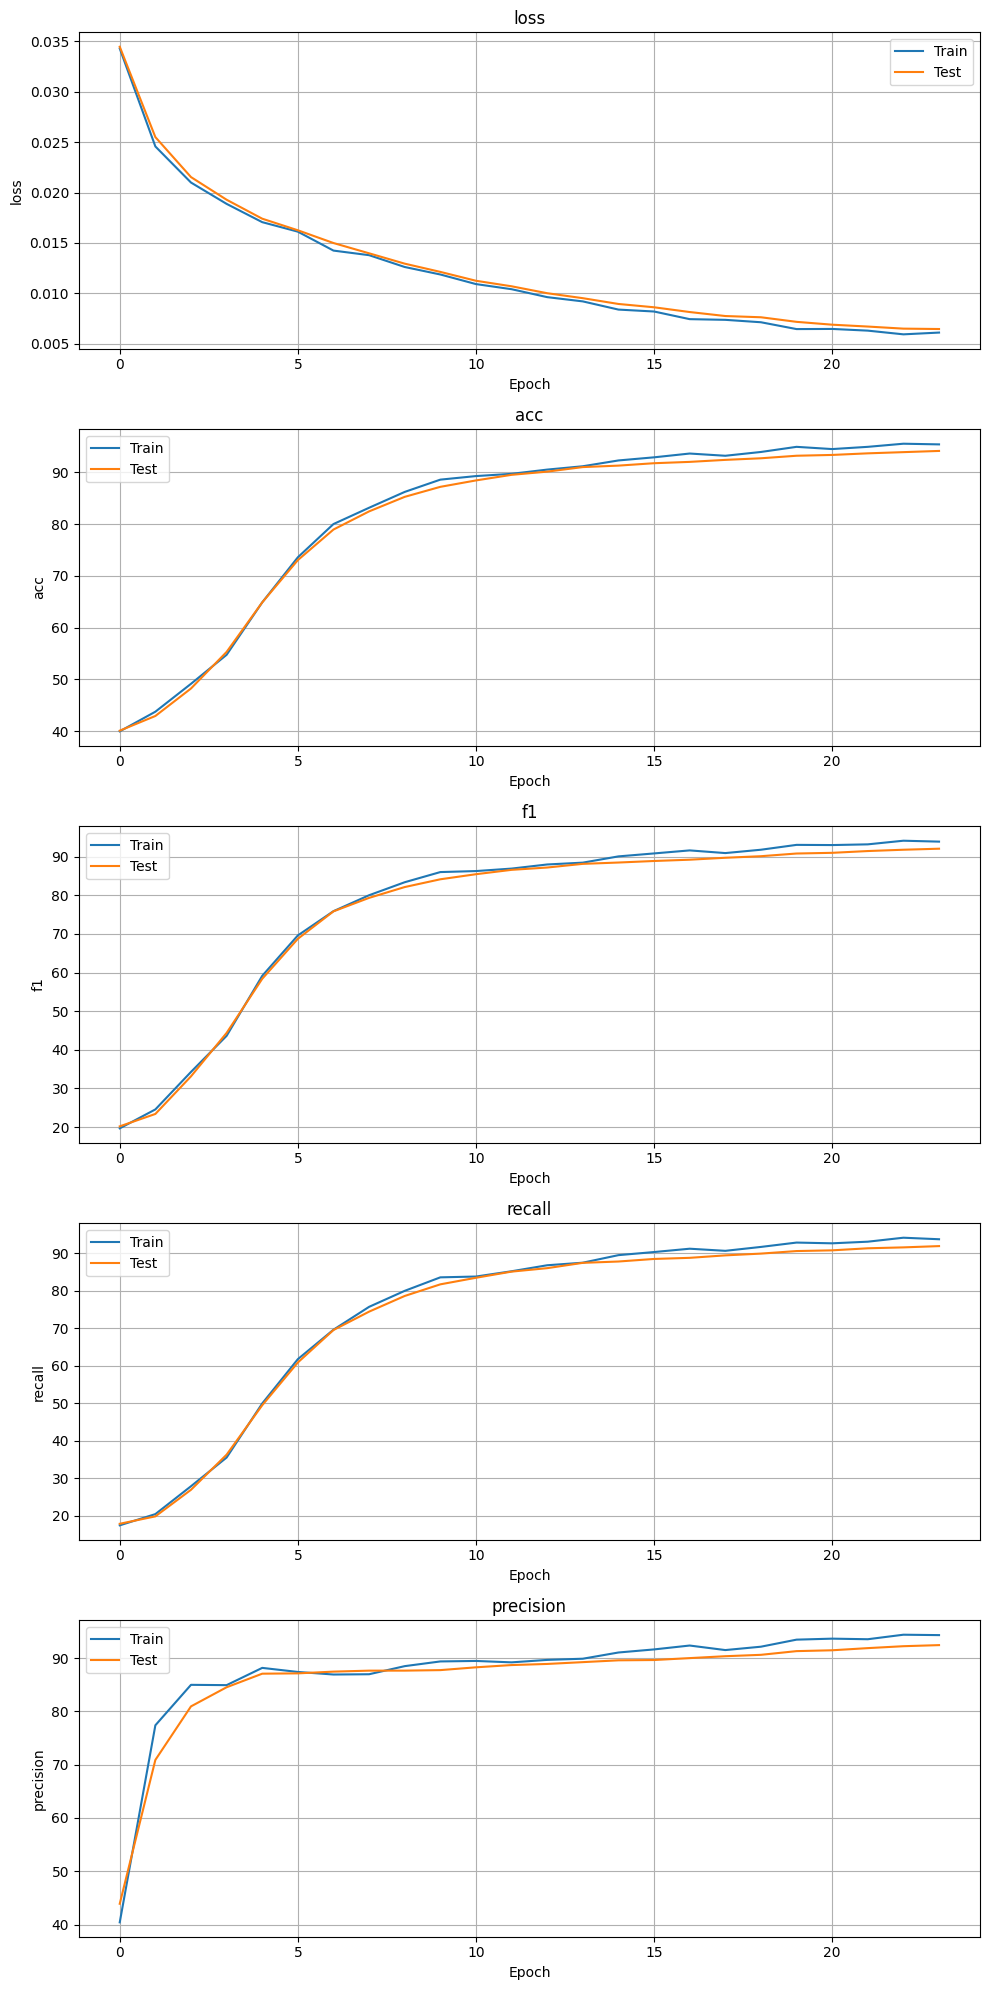

In [7]:
# Define the metrics
metrics = ["loss", "acc", "f1", "recall", "precision"]

# Create a figure and a set of subplots
fig, axs = plt.subplots(len(metrics), figsize=(10, 20))

# Iterate over each metric
for i, metric in enumerate(metrics):
    # Extract the metric values for training data
    train_values = [epoch[metric] for epoch in Train_history["Train"]]
    test_values = [epoch[metric] for epoch in Train_history["Val"]]

    # Check if the data is not empty
    if train_values:
        # Plot the metric for training data
        axs[i].plot(train_values, label="Train")
        axs[i].plot(test_values, label="Test")

        # Set the title, labels, and legend
        axs[i].set_title(metric)
        axs[i].set_xlabel("Epoch")
        axs[i].set_ylabel(metric)
        axs[i].legend()

        # Add a grid
        axs[i].grid(True)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## Analyse model Predicting performance

Raw Accuracy: 0.9401907708172209
Classification Report:
              precision    recall  f1-score   support

     Battery     0.9331    0.9612    0.9469       232
  Biological     0.9160    0.9836    0.9486       244
 Brown-glass     0.9405    0.9405    0.9405       168
   Cardboard     0.9087    0.9522    0.9299       209
     Clothes     0.9706    0.9870    0.9787      1305
 Green-glass     0.9565    0.9809    0.9686       157
       Metal     0.8541    0.8272    0.8404       191
       Paper     0.8977    0.8745    0.8860       271
     Plastic     0.8994    0.7559    0.8214       213
       Shoes     0.9727    0.9596    0.9661       520
       Trash     0.9565    0.9390    0.9477       164
 White-glass     0.8756    0.8585    0.8670       205

    accuracy                         0.9402      3879
   macro avg     0.9235    0.9183    0.9202      3879
weighted avg     0.9396    0.9402    0.9394      3879



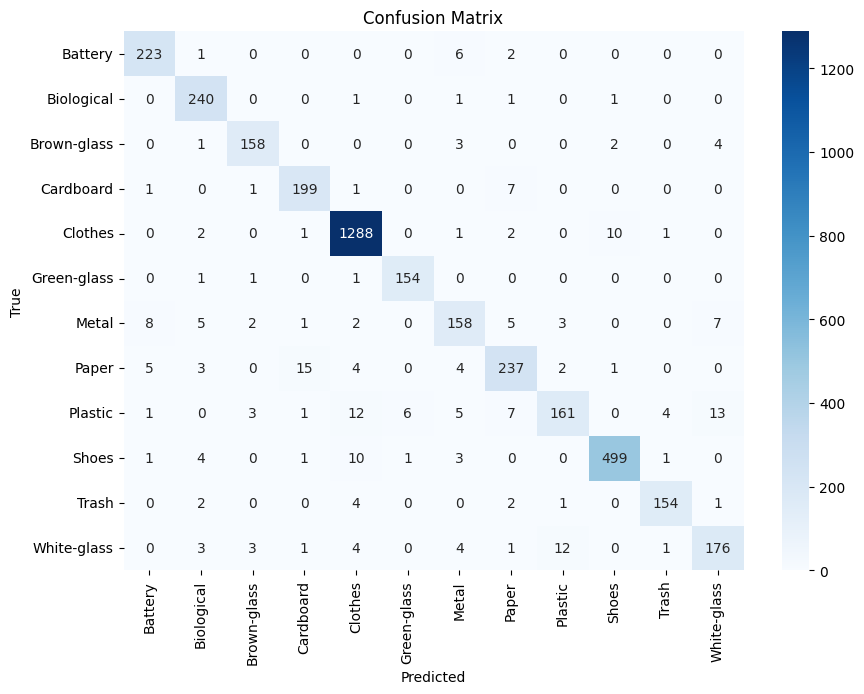

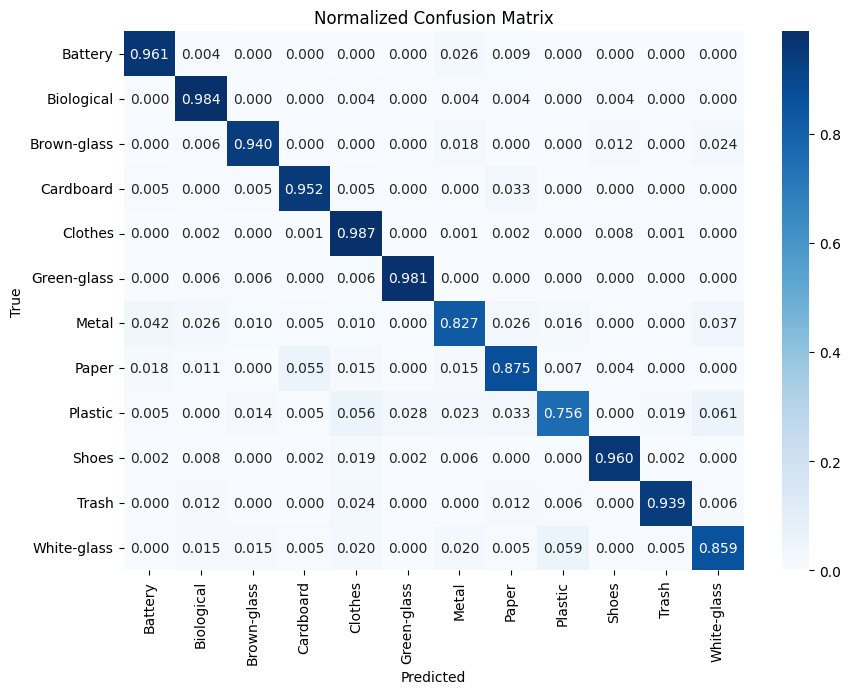

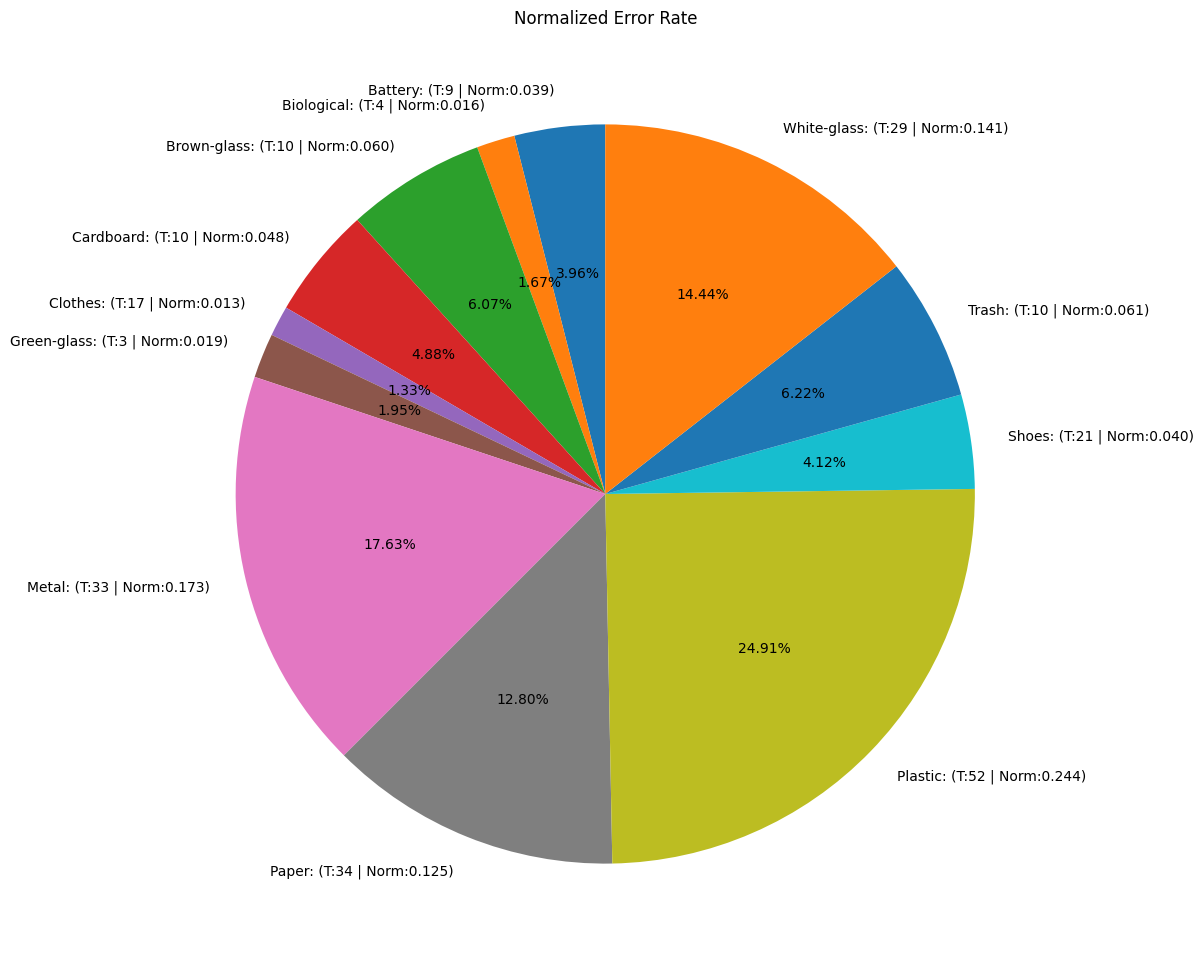

In [8]:
# Move the model to the device
model = model.to(device)

# Use the model to make predictions
model.eval()

# Define your batch size
batch_size = 32

# Initialize lists to hold the predictions and true values
y_pred_labels_list = []
y_test_labels_list = []

# Process each batch separately
for i in range(0, len(x_test), batch_size):
    x_test_batch = x_test[i : i + batch_size].to(device)
    y_test_batch = y_test[i : i + batch_size]

    with torch.no_grad():
        y_pred = model(x_test_batch)

    # Convert the predictions to a numpy array
    y_pred_np = y_pred.cpu().numpy()

    # Convert the one-hot encoded predictions to labels
    y_pred_labels = np.argmax(y_pred_np, axis=1)
    y_pred_labels_list.extend(y_pred_labels)

    # Convert the one-hot encoded true values to labels
    y_test_labels = np.argmax(y_test_batch.cpu().numpy(), axis=1)
    y_test_labels_list.extend(y_test_labels)

# Calculate the raw accuracy
raw_accuracy = accuracy_score(y_test_labels_list, y_pred_labels_list)

# Generate the classification report
report = classification_report(
    y_test_labels_list, y_pred_labels_list, target_names=labels, digits=4
)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_labels_list, y_pred_labels_list)

# Print the raw accuracy
print(f"Raw Accuracy: {raw_accuracy}")

# Print the classification report
print("Classification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Calculate the confusion matrix normalized by class support
conf_matrix_normalized = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix_normalized,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# Calculate the error rate for each class
error_rate = 1 - np.diag(conf_matrix_normalized)

# Calculate the number of misclassified samples for each class
misclassified_count = np.sum(conf_matrix - np.diag(np.diag(conf_matrix)), axis=1)

# Create a normalized pie chart with error rate and misclassified count
plt.figure(figsize=(16, 12))
plt.pie(
    error_rate,
    labels=[
        f"{label}: (T:{count} | Norm:{error_rate_PC:.3f})"
        for label, count, error_rate_PC in zip(labels, misclassified_count, error_rate)
    ],
    autopct="%1.2f%%",
    startangle=90,
)
plt.title("Normalized Error Rate")
plt.show()

## Example input

In [12]:
from PIL import Image

# image file name
image_name = "Exi.jpg"

# Load the model
model = torch.load("model.pth")

# Define the transformation
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
    ]
)

# Load the image
try:
    image = Image.open(image_name).resize((224, 224))
except Exception:
    print(f"Error: Image {image_name} not found")
else:
    # Apply the transformation to the image
    image = transform(image)

    # Add an extra dimension
    image = image.unsqueeze(0)  # type: ignore

    # Move the image and model to device
    image = image.to(device)
    model = model.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make a prediction
    output = model(image)

    # Get the predicted class
    _, predicted = torch.max(output, 1)

    # Calculate the confidence of the prediction
    confidence = nn.functional.softmax(output, dim=1)[0]
    for i, confid in enumerate(sorted(confidence.tolist(), reverse=True), start=1):
        print(
            f"{i}. {labels[confidence.tolist().index(confid)]} - confidence: {confid:.4%}"
        )

    # Get the predicted label
    predicted_label = labels[predicted]

    # Show the image with the predicted label and the confidence
    plt.imshow(Image.open(image_name))
    plt.title(
        f"Predicted: {predicted_label}, Confidence: {confidence[predicted].item():.4%}"
    )
    plt.show()

Error: Image Exi.jpg not found
